In [5]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
palette = sns.color_palette('colorblind')
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif',
    rc={'font.size':12, 'mathtext.fontset': 'cm', 'axes.labelpad':0, 'axes.linewidth': 0.5})

# WM

### Plot histogram of percent errors across subjects, colored by z

In [2]:
z0 = pd.read_pickle(f"data/WM_z0.pkl").query("type=='model-WM'")
z1 = pd.read_pickle(f"data/WM_z1.pkl").query("type=='model-WM'")
combined = pd.concat([z0, z1], ignore_index=True)

dfs = []
columns = ['type', 'sid', 'z', 'percent error']
for z in [0.0, 1.0]:  # combined['z'].unique():
    for sid in combined['sid'].unique():
        subdata = combined.query("z==@z & sid==@sid")
        errors = subdata['error'].to_numpy()
        if len(errors)==0:
            print(f"missing z={z} sid={sid}")
            continue
        percent_error = np.sum(errors) / len(errors)
        df = pd.DataFrame([['model-WM', sid, str(z), percent_error]], columns=columns)
        dfs.append(df)
reduced = pd.concat(dfs, ignore_index=True)

missing z=0.0 sid=82
missing z=0.0 sid=83
missing z=0.0 sid=84
missing z=0.0 sid=85
missing z=0.0 sid=86
missing z=1.0 sid=7
missing z=1.0 sid=21
missing z=1.0 sid=29
missing z=1.0 sid=45
missing z=1.0 sid=64
missing z=1.0 sid=77
missing z=1.0 sid=78
missing z=1.0 sid=81
missing z=1.0 sid=85
missing z=1.0 sid=86
missing z=1.0 sid=90
missing z=1.0 sid=95
missing z=1.0 sid=102
missing z=1.0 sid=118
missing z=1.0 sid=119
missing z=1.0 sid=186
missing z=1.0 sid=196


In [ ]:
reduced

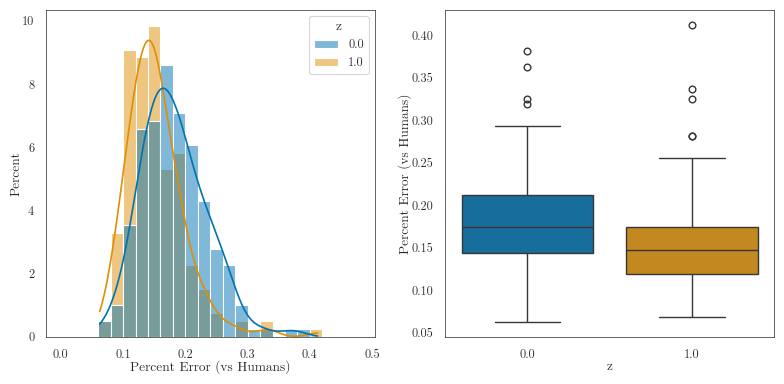

In [16]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
bins = np.arange(0.0, 0.5, 0.02)
sns.histplot(reduced, x='percent error', hue='z', ax=axes[0], hue_order=['0.0', '1.0'], stat='percent', palette=palette[:2], bins=bins, kde=True)
sns.boxplot(reduced, x='z', y='percent error', hue='z', hue_order=['0.0', '1.0'], palette=palette[:2], ax=axes[1])
axes[0].set(xlabel="Percent Error (vs Humans)") 
axes[1].set(xlabel="z", ylabel='Percent Error (vs Humans)') 
plt.tight_layout()
# fig.savefig("plots/wm_errors.png", dpi=600)

## WM

In [ ]:
data = pd.read_pickle(f"data/WMz1.pkl")
sids = data['sid'].unique()
errors1 = []
for sid in sids:
    df = data.query("sid==@sid")
    human_actions = df.query("type=='human'")['action'].to_numpy()
    model_actions = df.query("type=='model-WM'")['action'].to_numpy()
    error = len(np.where(model_actions != human_actions)[0]) / len(human_actions)
    errors1.append(error)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
bins = np.arange(0.0, 0.5, 0.02)
sns.histplot(errors0, ax=ax, stat='percent', color=palette[0], label='z=0', bins=bins, kde=True)
sns.histplot(errors1, ax=ax, stat='percent', color=palette[1], label='z=1', bins=bins, kde=True)
ax.set(xlabel="Number of trials when Model took a different action than Subject (percent)") 
ax.legend()
plt.tight_layout()
fig.savefig("plots/wm_errors.png", dpi=600)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(errors0, ax=ax, stat='percent', color=palette[0], label='z=0')
sns.histplot(errors1, ax=ax, stat='percent', color=palette[1], label='z=1')
ax.set(xlabel="Number of trials when Model took a different action than Subject (percent)") 
plt.tight_layout()
fig.savefig("plots/wm_errors.png", dpi=600)

In [ ]:
empirical = pd.read_pickle("data/behavior.pkl")
print(empirical['RD'].max())